<a href="https://colab.research.google.com/github/ahmedhamodien/Machine-Learning-/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Github clone

In [1]:
!git clone https://github.com/your_username/Machine_Learning.git
%cd face-mask-detection


Cloning into 'Machine_Learning'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: 'face-mask-detection'
/content


# Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

from tensorflow.keras.applications.densenet import preprocess_input

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from tqdm.keras import TqdmCallback

# Data preprocessing

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedhamodien","key":"5753d07a0e9a5fb93f192eec273677a3"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset


Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
License(s): CC0-1.0
 97% 320M/330M [00:00<00:00, 649MB/s]
100% 330M/330M [00:00<00:00, 695MB/s]


In [6]:
import zipfile

zip_ref = zipfile.ZipFile("face-mask-12k-images-dataset.zip", 'r')
zip_ref.extractall("face_mask_dataset_after_extraction")
zip_ref.close()


In [7]:
train_dir = '/content/face_mask_dataset_after_extraction'
train_dir

'/content/face_mask_dataset_after_extraction'

In [8]:
os.path.exists(train_dir)


True

In [9]:
import os
print(os.listdir("/content"))


['.config', 'face_mask_dataset_after_extraction', 'face-mask-12k-images-dataset.zip', 'kaggle.json', 'sample_data']


In [10]:
for root, dirs, files in os.walk("/content"):
    print(f"📁 {root}")
    for d in dirs:
        print(f"  📂 {d}")
    for f in files[:5]:  # Only show first 5 files per folder
        print(f"  🖼️ {f}")


📁 /content
  📂 .config
  📂 face_mask_dataset_after_extraction
  📂 sample_data
  🖼️ face-mask-12k-images-dataset.zip
  🖼️ kaggle.json
📁 /content/.config
  📂 logs
  📂 configurations
  🖼️ default_configs.db
  🖼️ .last_opt_in_prompt.yaml
  🖼️ config_sentinel
  🖼️ hidden_gcloud_config_universe_descriptor_data_cache_configs.db
  🖼️ active_config
📁 /content/.config/logs
  📂 2025.07.29
📁 /content/.config/logs/2025.07.29
  🖼️ 13.36.15.785307.log
  🖼️ 13.36.36.776594.log
  🖼️ 13.36.37.567476.log
  🖼️ 13.36.27.119914.log
  🖼️ 13.35.49.066514.log
📁 /content/.config/configurations
  🖼️ config_default
📁 /content/face_mask_dataset_after_extraction
  📂 Face Mask Dataset
📁 /content/face_mask_dataset_after_extraction/Face Mask Dataset
  📂 Validation
  📂 Train
  📂 Test
📁 /content/face_mask_dataset_after_extraction/Face Mask Dataset/Validation
  📂 WithMask
  📂 WithoutMask
📁 /content/face_mask_dataset_after_extraction/Face Mask Dataset/Validation/WithMask
  🖼️ Augmented_646_7625934.png
  🖼️ Augmented_223_6

In [11]:
import os


classes = sorted(os.listdir(train_dir))

print("Detected classes:", classes)
import os

# List files in root
print(os.listdir("/content"))
print(os.listdir("/content/face_mask_dataset_after_extraction/Face Mask Dataset/Train"))



Detected classes: ['Face Mask Dataset']
['.config', 'face_mask_dataset_after_extraction', 'face-mask-12k-images-dataset.zip', 'kaggle.json', 'sample_data']
['WithMask', 'WithoutMask']


In [12]:
train_dir = "face_mask_dataset_after_extraction/Face Mask Dataset/Train"


In [13]:
import os
import pandas as pd

# Change this to your actual folder on Colab after uploadiface_mask_dataset_after_extraction/Face Mask Datasetng from Kaggle

filepaths = []
labels = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_path, file)
                filepaths.append(filepath)
                labels.append(class_name)

import pandas as pd
train_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print(train_df.head())
print("Total images found:", len(train_df))

                                           filepaths    labels
0  face_mask_dataset_after_extraction/Face Mask D...  WithMask
1  face_mask_dataset_after_extraction/Face Mask D...  WithMask
2  face_mask_dataset_after_extraction/Face Mask D...  WithMask
3  face_mask_dataset_after_extraction/Face Mask D...  WithMask
4  face_mask_dataset_after_extraction/Face Mask D...  WithMask
Total images found: 10000


In [14]:
print(filepaths[0])
print(os.path.exists(filepaths[0]))  # Should be True


face_mask_dataset_after_extraction/Face Mask Dataset/Train/WithMask/Augmented_374_1747794.png
True


In [15]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

print("Train size:", len(train_data))
print("Validation size:", len(val_data))


Train size: 8000
Validation size: 2000


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image generators
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=20,
                               zoom_range=0.2,
                               horizontal_flip=True)

val_gen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe
train_flow = train_gen.flow_from_dataframe(train_data,
                                           x_col='filepaths',
                                           y_col='labels',
                                           target_size=(224, 224),
                                           class_mode='binary',
                                           batch_size=32,
                                           shuffle=True)

val_flow = val_gen.flow_from_dataframe(val_data,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=(224, 224),
                                       class_mode='binary',
                                       batch_size=32,
                                       shuffle=True)


Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(1, activation='sigmoid'),
    Dense(1, activation='sigmoid')  # ⬅️ 1 output neuron for binary
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
print(train_df['labels'].unique())
print(train_df['labels'].nunique())


['WithMask' 'WithoutMask']
2


In [19]:
print(len(train_data))
print(train_data.head())
import os

# Test one image path
print(filepaths[0])
print(os.path.exists(filepaths[0]))


8000
                                              filepaths       labels
2858  face_mask_dataset_after_extraction/Face Mask D...     WithMask
6842  face_mask_dataset_after_extraction/Face Mask D...  WithoutMask
3905  face_mask_dataset_after_extraction/Face Mask D...     WithMask
7684  face_mask_dataset_after_extraction/Face Mask D...  WithoutMask
1564  face_mask_dataset_after_extraction/Face Mask D...     WithMask
face_mask_dataset_after_extraction/Face Mask Dataset/Train/WithMask/Augmented_374_1747794.png
True


In [20]:
print(train_data.shape)
print(val_data.shape)

(8000, 2)
(2000, 2)


In [21]:
print("Train samples:", train_flow.samples)
print("Val samples:", val_flow.samples)


Train samples: 8000
Val samples: 2000


In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['encoded_labels'] = le.fit_transform(train_df['labels'])  # e.g., 'with_mask' → 1, 'without_mask' → 0


In [23]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(train_df['encoded_labels'])  # or use pd.get_dummies


In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(train_flow,
                    validation_data=val_flow,
                    epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 379ms/step - accuracy: 0.4998 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 377ms/step - accuracy: 0.5033 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 376ms/step - accuracy: 0.5082 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 375ms/step - accuracy: 0.4993 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 375ms/step - accuracy: 0.5090 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 93s 374ms/step - accuracy: 0.5101 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 381ms/step - accuracy: 0.5024 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
License(s): CC0-1.0
face-mask-12k-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
📊 Class Distribution:
labels
WithMask       5000
WithoutMask    5000
Name: count, dtype: int64
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 114s 412ms/step - accuracy: 0.9391 - loss: 0.1536 - val_accuracy: 0.9885 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 388ms/step - accuracy: 0.9814 - loss: 0.0531 - val_accuracy: 0.9910 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 98s 392ms/step - accuracy: 0.9833 - loss: 0.0478 - val_accuracy: 0.9865 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 386ms/step - accuracy: 0.9832 - loss: 0.0473 - val_accuracy: 0.9960 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 384ms/step - accuracy: 0.9868 - loss: 0.0344 - val_accuracy: 0.9875 - val_loss: 0.0289 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 96s 382ms/step - accuracy: 0.9884 - loss: 0.0305 - val_accuracy: 0.9970 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 380ms/step - accuracy

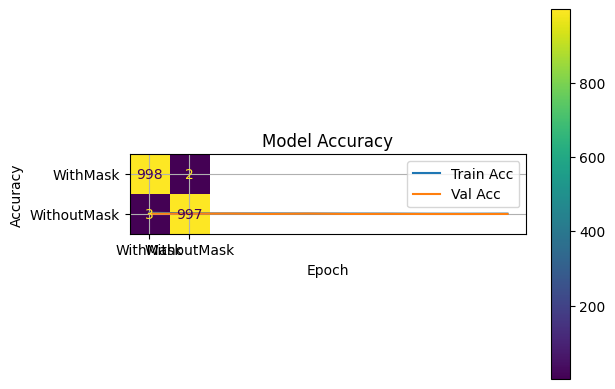

In [25]:
# -------------------------------
# 📦 Imports
# -------------------------------
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# -------------------------------
# ⬇️ Load + Extract Dataset
# -------------------------------
from google.colab import files
files.upload()  # Upload kaggle.json manually

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

with zipfile.ZipFile("face-mask-12k-images-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("face_mask_dataset_after_extraction")

# -------------------------------
# 📂 Load File Paths
# -------------------------------
data_dir = "/content/face_mask_dataset_after_extraction/Face Mask Dataset/Train"

filepaths = []
labels = []

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                filepaths.append(os.path.join(class_path, file))
                labels.append(class_name)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print("📊 Class Distribution:")
print(df['labels'].value_counts())

# -------------------------------
# 🧪 Train/Test Split
# -------------------------------
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# -------------------------------
# 🔄 Data Generators
# -------------------------------
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=20,
                               zoom_range=0.2,
                               horizontal_flip=True)

val_gen = ImageDataGenerator(rescale=1./255)

train_flow = train_gen.flow_from_dataframe(train_df,
                                           x_col='filepaths',
                                           y_col='labels',
                                           target_size=(224, 224),
                                           class_mode='binary',
                                           batch_size=32,
                                           shuffle=True)

val_flow = val_gen.flow_from_dataframe(val_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=(224, 224),
                                       class_mode='binary',
                                       batch_size=32,
                                       shuffle=False)

# -------------------------------
# 🧠 Model (Transfer Learning)
# -------------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# -------------------------------
# ⚖️ Handle Class Imbalance
# -------------------------------
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df['labels']),
                                     y=df['labels'])

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# -------------------------------
# ⏱️ Training
# -------------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2)
]

history = model.fit(train_flow,
                    validation_data=val_flow,
                    epochs=10,
                    class_weight=class_weight_dict,
                    callbacks=callbacks)

# -------------------------------
# 📈 Evaluation
# -------------------------------
preds = model.predict(val_flow)
pred_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_flow.classes

print("\n🧾 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=val_flow.class_indices))

print("\n🌀 Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, display_labels=val_flow.class_indices)

# -------------------------------
# 📊 Plot Training History
# -------------------------------
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
